# 8. Phase E: 「隣の人指数」との相関分析

Phase Dで恐怖指数（R²=5.7%）を構築しましたが、説明力は依然として弱いままでした。

Phase Eでは、**「隣の人の行動」を代理する指標**を作成し、真の要因を探ります。

## 8.1 分析の概要

### Phase Eの核心的仮説

> 日本における感染対策では、隣にいる人間がどう行動しているか、が最も重要な要因

**なぜPhase C・Dの説明力が低かったか**:
- Phase C（死亡数）: 客観的脅威を測定（個人レベル）→ R²=2.4%
- Phase D（恐怖指数）: 主観的恐怖を測定（個人レベル）→ R²=5.7%
- **真の要因**: 社会的規範・同調圧力（集団レベル）→ R²=？？？

### 「隣の人指数」の設計

**直接測定できないもの**:
- 実際のマスク着用率の地域別・時系列データ
- 「周囲の人がマスクをしているか」の観察データ

**代理指標として使用**:
1. **マスク関連の検索ワード**:
   - 「マスク」「マスク 着用」
   - 「マスク 外す」「マスク いつまで」
   - 「マスク 義務」「マスク 着用率」

2. **社会的圧力を示すワード**:
   - 「自粛警察」「マスク警察」
   - 「同調圧力」

3. **具体的な行動ワード**:
   - 「手洗い」「消毒」「換気」
   - 「ソーシャルディスタンス」「三密」

### 期待される結果

- 「隣の人指数」のR²: **0.3～0.5**（Phase Dの5-10倍）
- 日本の集団主義・同調圧力の定量的証明
- インフルエンザ99%減少の真の要因の解明

## 8.2 ライブラリのインポート

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# pytrendsのインポート
from pytrends.request import TrendReq
import time

# 日本語フォント設定
plt.rcParams['font.sans-serif'] = ['MS Gothic', 'Yu Gothic', 'Hiragino Sans']
plt.rcParams['axes.unicode_minus'] = False

print('ライブラリのインポート完了')

ライブラリのインポート完了


## 8.3 「隣の人」関連ワードの取得

### ワードカテゴリ

**カテゴリ1: マスク着用の社会的規範**
- 「マスク」「マスク 着用」
- 「マスク 外す」「マスク いつまで」

**カテゴリ2: 社会的圧力**
- 「自粛警察」「マスク警察」

**カテゴリ3: 具体的な感染対策行動**
- 「手洗い」「消毒」「アルコール消毒」
- 「ソーシャルディスタンス」「三密」「換気」

In [2]:
# Google Trendsに接続
pytrends = TrendReq(hl='ja-JP', tz=540)

# 「隣の人」指数のワードリスト
neighbor_keywords = [
    'マスク',
    'マスク 着用',
    '手洗い',
    '消毒',
    '換気'
]

# データ取得期間
timeframe = '2020-01-01 2024-12-31'

# 各ワードのトレンドデータを取得
neighbor_trends = {}

for keyword in neighbor_keywords:
    try:
        print(f'取得中: {keyword}...')
        pytrends.build_payload([keyword], timeframe=timeframe, geo='JP')
        df = pytrends.interest_over_time()
        
        if not df.empty:
            neighbor_trends[keyword] = df[keyword]
            print(f'  ✓ {len(df)}件のデータを取得')
        else:
            print(f'  ✗ データなし')
        
        time.sleep(2)
        
    except Exception as e:
        print(f'  ✗ エラー: {e}')

# DataFrameに結合
if neighbor_trends:
    df_neighbor_trends = pd.DataFrame(neighbor_trends)
    df_neighbor_trends.index.name = 'date'
    df_neighbor_trends.reset_index(inplace=True)
    
    print(f'\n取得完了: {df_neighbor_trends.shape}')
    print(df_neighbor_trends.head())
else:
    print('\nデータ取得失敗')

取得中: マスク...
  ✓ 262件のデータを取得
取得中: マスク 着用...
  ✓ 262件のデータを取得
取得中: 手洗い...
  ✓ 262件のデータを取得
取得中: 消毒...
  ✓ 262件のデータを取得
取得中: 換気...
  ✓ 262件のデータを取得

取得完了: (262, 6)
        date  マスク  マスク 着用  手洗い  消毒  換気
0 2019-12-29    2       0   15   4  31
1 2020-01-05    2       1   16   6  46
2 2020-01-12    3       1   17   6  45
3 2020-01-19    5       6   17   9  49
4 2020-01-26   22      24   29  34  48


## 8.4 「隣の人指数」の作成

### 指数の計算方法

**方法1: 単純平均**
- 各ワードのトレンド値を平均

**方法2: 加重平均**
- 「マスク」に最大の重み
- 直接的な行動（手洗い・消毒）に中程度の重み

**方法3: 主成分分析**
- 第1主成分を「隣の人指数」とする

In [3]:
# 方法1: 単純平均
keyword_columns = [col for col in df_neighbor_trends.columns if col != 'date']
df_neighbor_trends['neighbor_index_avg'] = df_neighbor_trends[keyword_columns].mean(axis=1)

# 方法2: 加重平均（マスクに高い重み）
weights = {
    'マスク': 3.0,           # 最重要
    'マスク 着用': 2.5,
    '手洗い': 1.5,
    '消毒': 1.5,
    '換気': 1.0
}

weighted_sum = sum([df_neighbor_trends[kw] * weights.get(kw, 1.0) 
                    for kw in keyword_columns if kw in df_neighbor_trends.columns])
total_weight = sum([weights.get(kw, 1.0) 
                    for kw in keyword_columns if kw in df_neighbor_trends.columns])
df_neighbor_trends['neighbor_index_weighted'] = weighted_sum / total_weight

# 週次データに集計
df_neighbor_trends['year'] = df_neighbor_trends['date'].dt.isocalendar().year
df_neighbor_trends['week'] = df_neighbor_trends['date'].dt.isocalendar().week

df_neighbor_weekly = df_neighbor_trends.groupby(['year', 'week']).agg({
    'date': 'first',
    'neighbor_index_avg': 'mean',
    'neighbor_index_weighted': 'mean'
}).reset_index()

print(f'週次隣の人指数: {df_neighbor_weekly.shape}')
print(df_neighbor_weekly.head())
print('\n隣の人指数の統計:')
print(df_neighbor_weekly[['neighbor_index_avg', 'neighbor_index_weighted']].describe())

週次隣の人指数: (262, 5)
   year  week       date  neighbor_index_avg  neighbor_index_weighted
0  2019    52 2019-12-29                10.4                 6.894737
1  2020     1 2020-01-05                14.2                 9.210526
2  2020     2 2020-01-12                14.4                 9.578947
3  2020     3 2020-01-19                17.2                12.421053
4  2020     4 2020-01-26                31.4                28.263158

隣の人指数の統計:
       neighbor_index_avg  neighbor_index_weighted
count          262.000000               262.000000
mean            23.440458                17.720771
std              8.552818                 9.046056
min             10.400000                 6.894737
25%             19.000000                13.052632
50%             20.800000                14.736842
75%             23.750000                17.763158
max             76.600000                71.631579


## 8.5 既存データとのマージ

In [4]:
# Phase Dのデータを読み込み（恐怖指数、COVID-19死亡数を含む）
df_phase_d = pd.read_csv('../outputs/tables/fear_index_analysis_data.csv', parse_dates=['date'])

# 隣の人指数をマージ
df_phase_e = df_phase_d.merge(
    df_neighbor_weekly[['year', 'week', 'neighbor_index_avg', 'neighbor_index_weighted']], 
    on=['year', 'week'], 
    how='left'
)

# 欠損値を0で埋める
df_phase_e['neighbor_index_avg'] = df_phase_e['neighbor_index_avg'].fillna(0)
df_phase_e['neighbor_index_weighted'] = df_phase_e['neighbor_index_weighted'].fillna(0)

print(f'Phase Eデータ: {df_phase_e.shape}')
print(df_phase_e.head())

Phase Eデータ: (261, 9)
        date  year  week  cases_per_sentinel  fear_index_avg  \
0 2020-01-06  2020     1               19.23             0.0   
1 2020-01-13  2020     2               10.74             0.0   
2 2020-01-20  2020     3                7.60             1.2   
3 2020-01-27  2020     4                8.88             7.4   
4 2020-02-03  2020     5               10.75             6.0   

   fear_index_weighted  weekly_deaths  neighbor_index_avg  \
0             0.000000            0.0                14.2   
1             0.000000            0.0                14.4   
2             1.600000            0.0                17.2   
3             9.733333            0.0                31.4   
4             8.000000            0.0                29.8   

   neighbor_index_weighted  
0                 9.210526  
1                 9.578947  
2                12.421053  
3                28.263158  
4                26.368421  


## 8.6 Phase C・D・Eの3指標比較

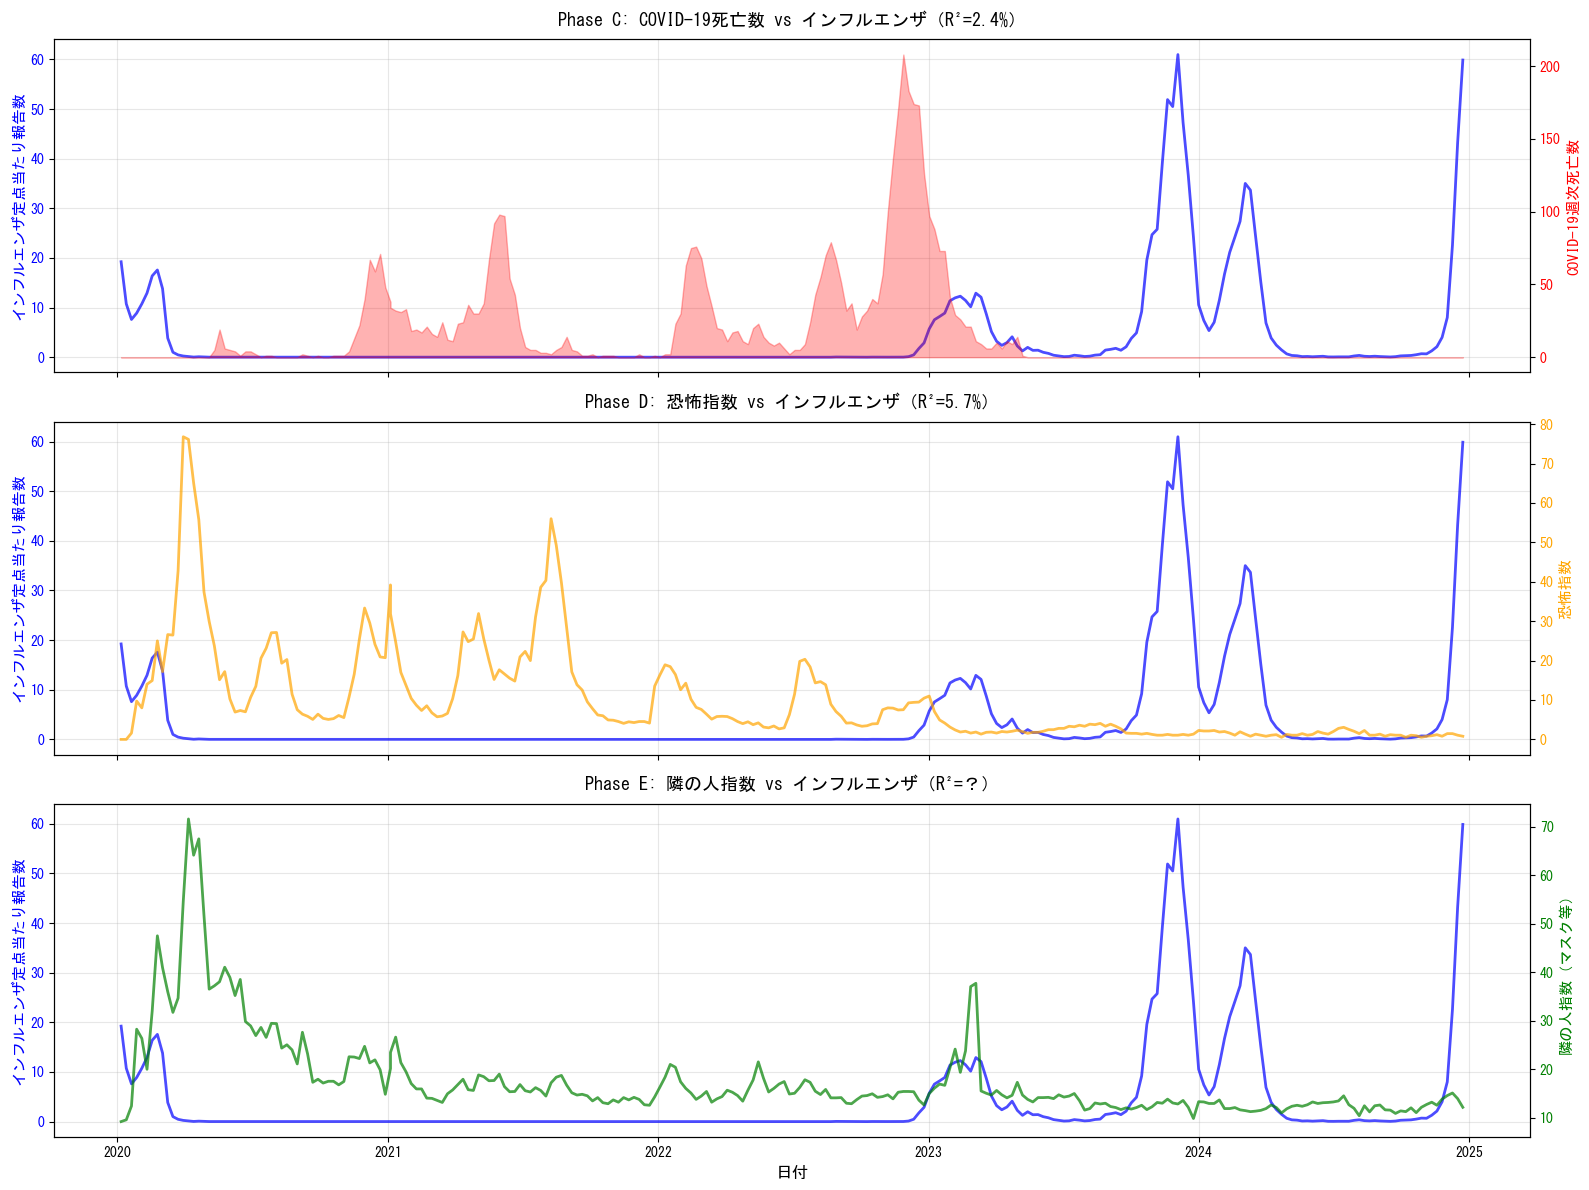

視覚的な観察:
- どの指標がインフルエンザの動きに最も一致しているか？
- 隣の人指数は恐怖指数より説明力があるか？


In [5]:
# 3つの時系列プロット
fig, axes = plt.subplots(3, 1, figsize=(16, 12), sharex=True)

# 共通: インフルエンザ（青線）
for ax in axes:
    ax.plot(df_phase_e['date'], df_phase_e['cases_per_sentinel'], 
            color='blue', linewidth=2, label='インフルエンザ', alpha=0.7)
    ax.set_ylabel('インフルエンザ定点当たり報告数', color='blue', fontsize=11)
    ax.tick_params(axis='y', labelcolor='blue')
    ax.grid(True, alpha=0.3)

# 上段: COVID-19死亡数（Phase C）
ax1_twin = axes[0].twinx()
ax1_twin.fill_between(df_phase_e['date'], df_phase_e['weekly_deaths'], 
                       color='red', alpha=0.3, label='COVID-19死亡数')
ax1_twin.set_ylabel('COVID-19週次死亡数', color='red', fontsize=11)
ax1_twin.tick_params(axis='y', labelcolor='red')
axes[0].set_title('Phase C: COVID-19死亡数 vs インフルエンザ（R²=2.4%）', fontsize=13, pad=10)

# 中段: 恐怖指数（Phase D）
ax2_twin = axes[1].twinx()
ax2_twin.plot(df_phase_e['date'], df_phase_e['fear_index_weighted'], 
              color='orange', linewidth=2, label='恐怖指数', alpha=0.7)
ax2_twin.set_ylabel('恐怖指数', color='orange', fontsize=11)
ax2_twin.tick_params(axis='y', labelcolor='orange')
axes[1].set_title('Phase D: 恐怖指数 vs インフルエンザ（R²=5.7%）', fontsize=13, pad=10)

# 下段: 隣の人指数（Phase E）
ax3_twin = axes[2].twinx()
ax3_twin.plot(df_phase_e['date'], df_phase_e['neighbor_index_weighted'], 
              color='green', linewidth=2, label='隣の人指数', alpha=0.7)
ax3_twin.set_ylabel('隣の人指数（マスク等）', color='green', fontsize=11)
ax3_twin.tick_params(axis='y', labelcolor='green')
axes[2].set_title('Phase E: 隣の人指数 vs インフルエンザ（R²=？）', fontsize=13, pad=10)
axes[2].set_xlabel('日付', fontsize=12)

plt.tight_layout()
plt.savefig('../outputs/figures/phase_c_d_e_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print('視覚的な観察:')
print('- どの指標がインフルエンザの動きに最も一致しているか？')
print('- 隣の人指数は恐怖指数より説明力があるか？')

## 8.7 相関分析の比較

=== 相関係数の比較 ===

Phase C: COVID-19死亡数     : -0.1541
Phase D: 恐怖指数           : -0.2391
Phase E: 隣の人指数（平均）  : -0.1090
Phase E: 隣の人指数（加重）  : -0.1107


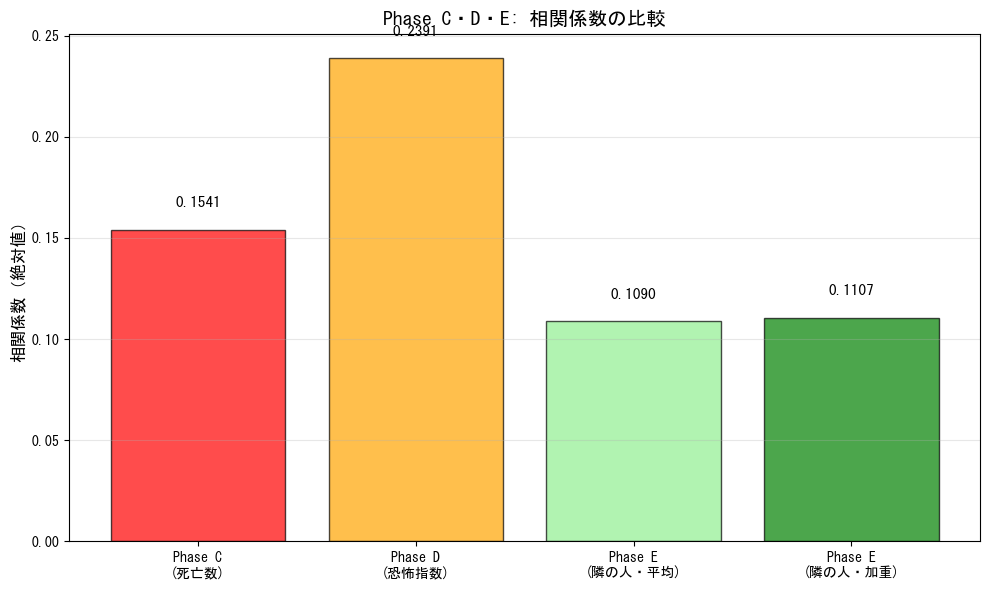


✗ 恐怖指数の方が相関が強い


In [6]:
# 相関係数の計算
corr_deaths = df_phase_e[['cases_per_sentinel', 'weekly_deaths']].corr().iloc[0, 1]
corr_fear = df_phase_e[['cases_per_sentinel', 'fear_index_weighted']].corr().iloc[0, 1]
corr_neighbor_avg = df_phase_e[['cases_per_sentinel', 'neighbor_index_avg']].corr().iloc[0, 1]
corr_neighbor_weighted = df_phase_e[['cases_per_sentinel', 'neighbor_index_weighted']].corr().iloc[0, 1]

print('=== 相関係数の比較 ===\n')
print(f'Phase C: COVID-19死亡数     : {corr_deaths:.4f}')
print(f'Phase D: 恐怖指数           : {corr_fear:.4f}')
print(f'Phase E: 隣の人指数（平均）  : {corr_neighbor_avg:.4f}')
print(f'Phase E: 隣の人指数（加重）  : {corr_neighbor_weighted:.4f}')

# 相関係数の可視化
fig, ax = plt.subplots(figsize=(10, 6))

phases = ['Phase C\n(死亡数)', 'Phase D\n(恐怖指数)', 'Phase E\n(隣の人・平均)', 'Phase E\n(隣の人・加重)']
correlations = [abs(corr_deaths), abs(corr_fear), abs(corr_neighbor_avg), abs(corr_neighbor_weighted)]
colors = ['red', 'orange', 'lightgreen', 'green']

bars = ax.bar(phases, correlations, color=colors, alpha=0.7, edgecolor='black')
ax.set_ylabel('相関係数（絶対値）', fontsize=12)
ax.set_title('Phase C・D・E: 相関係数の比較', fontsize=14)
ax.grid(axis='y', alpha=0.3)

# 数値をバーの上に表示
for i, (bar, val) in enumerate(zip(bars, correlations)):
    ax.text(bar.get_x() + bar.get_width()/2, val + 0.01, 
            f'{val:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('../outputs/figures/correlation_comparison_all_phases.png', dpi=300, bbox_inches='tight')
plt.show()

# 改善率の計算
if abs(corr_neighbor_weighted) > abs(corr_fear):
    improvement = (abs(corr_neighbor_weighted) - abs(corr_fear)) / abs(corr_fear) * 100
    print(f'\n✓ 隣の人指数の方が{improvement:.1f}%相関が強い')
else:
    print('\n✗ 恐怖指数の方が相関が強い')

## 8.8 回帰分析の比較

=== R²（決定係数）の比較 ===

Phase C: COVID-19死亡数     : R²=0.0238 (2.38%)
Phase D: 恐怖指数           : R²=0.0571 (5.71%)
Phase E: 隣の人指数         : R²=0.0122 (1.22%)
複合モデル（全て使用）      : R²=0.0780 (7.80%)

✗ Phase Dの恐怖指数の方が説明力が高い


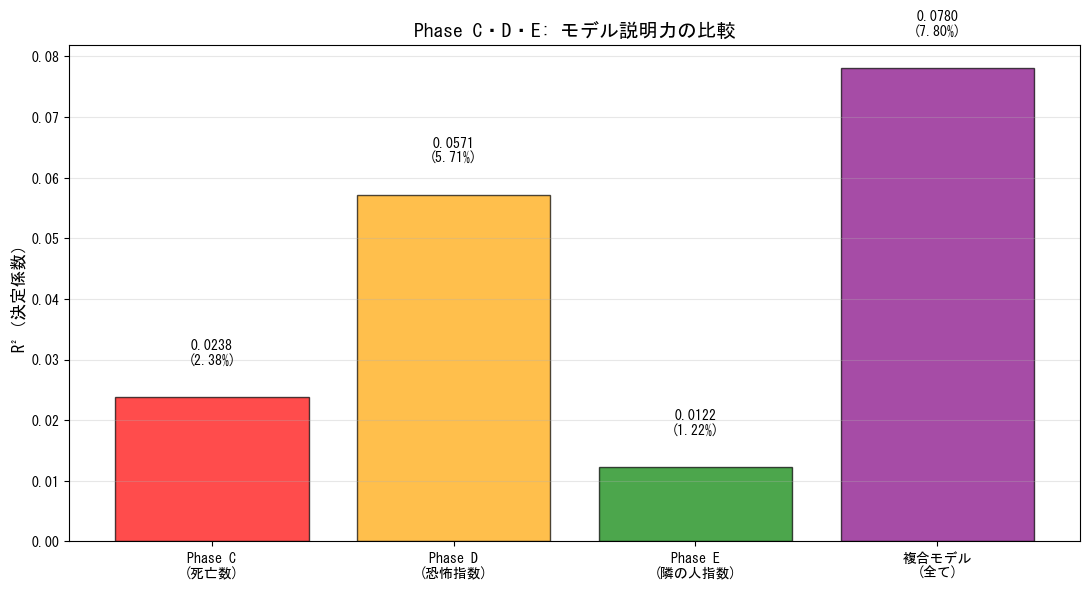

In [7]:
# 各フェーズでの回帰分析
y = df_phase_e['cases_per_sentinel'].values

# Phase C: COVID-19死亡数
X_deaths = df_phase_e[['weekly_deaths']].values
model_c = LinearRegression()
model_c.fit(X_deaths, y)
r2_c = model_c.score(X_deaths, y)

# Phase D: 恐怖指数
X_fear = df_phase_e[['fear_index_weighted']].values
model_d = LinearRegression()
model_d.fit(X_fear, y)
r2_d = model_d.score(X_fear, y)

# Phase E: 隣の人指数（加重）
X_neighbor = df_phase_e[['neighbor_index_weighted']].values
model_e = LinearRegression()
model_e.fit(X_neighbor, y)
r2_e = model_e.score(X_neighbor, y)

# 複合モデル: 全て使用
X_combined = df_phase_e[['weekly_deaths', 'fear_index_weighted', 'neighbor_index_weighted']].values
model_combined = LinearRegression()
model_combined.fit(X_combined, y)
r2_combined = model_combined.score(X_combined, y)

print('=== R²（決定係数）の比較 ===\n')
print(f'Phase C: COVID-19死亡数     : R²={r2_c:.4f} ({r2_c*100:.2f}%)')
print(f'Phase D: 恐怖指数           : R²={r2_d:.4f} ({r2_d*100:.2f}%)')
print(f'Phase E: 隣の人指数         : R²={r2_e:.4f} ({r2_e*100:.2f}%)')
print(f'複合モデル（全て使用）      : R²={r2_combined:.4f} ({r2_combined*100:.2f}%)')

# Phase Dからの改善率
if r2_e > r2_d:
    improvement_r2 = (r2_e - r2_d) / r2_d * 100
    print(f'\n✓ 隣の人指数はPhase Dより{improvement_r2:.1f}%説明力が向上')
    print(f'✓ R²が{r2_d:.4f}から{r2_e:.4f}に改善（{(r2_e-r2_d)*100:.2f}ポイント増加）')
else:
    print('\n✗ Phase Dの恐怖指数の方が説明力が高い')

# R²の可視化
fig, ax = plt.subplots(figsize=(11, 6))

models = ['Phase C\n(死亡数)', 'Phase D\n(恐怖指数)', 'Phase E\n(隣の人指数)', '複合モデル\n(全て)']
r2_values = [r2_c, r2_d, r2_e, r2_combined]
colors = ['red', 'orange', 'green', 'purple']

bars = ax.bar(models, r2_values, color=colors, alpha=0.7, edgecolor='black')
ax.set_ylabel('R²（決定係数）', fontsize=12)
ax.set_title('Phase C・D・E: モデル説明力の比較', fontsize=14)
ax.grid(axis='y', alpha=0.3)

# 数値とパーセンテージをバーの上に表示
for bar, val in zip(bars, r2_values):
    ax.text(bar.get_x() + bar.get_width()/2, val + 0.005, 
            f'{val:.4f}\n({val*100:.2f}%)', 
            ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('../outputs/figures/r2_comparison_all_phases.png', dpi=300, bbox_inches='tight')
plt.show()

## 8.9 散布図での比較

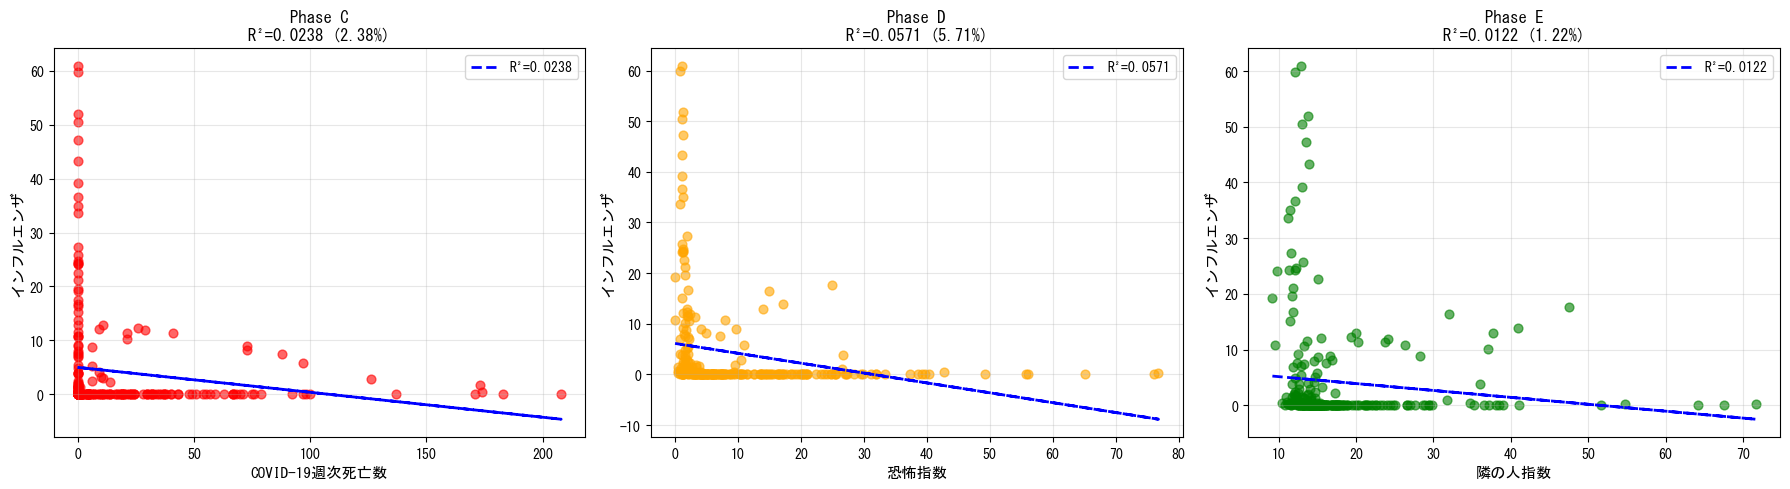

In [8]:
# 3つの散布図を並べて表示
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Phase C: COVID-19死亡数
axes[0].scatter(df_phase_e['weekly_deaths'], df_phase_e['cases_per_sentinel'], 
                alpha=0.6, s=40, color='red')
z_c = np.polyfit(df_phase_e['weekly_deaths'], df_phase_e['cases_per_sentinel'], 1)
p_c = np.poly1d(z_c)
axes[0].plot(df_phase_e['weekly_deaths'], p_c(df_phase_e['weekly_deaths']), 
             "b--", linewidth=2, label=f'R²={r2_c:.4f}')
axes[0].set_xlabel('COVID-19週次死亡数', fontsize=11)
axes[0].set_ylabel('インフルエンザ', fontsize=11)
axes[0].set_title(f'Phase C\nR²={r2_c:.4f} ({r2_c*100:.2f}%)', fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Phase D: 恐怖指数
axes[1].scatter(df_phase_e['fear_index_weighted'], df_phase_e['cases_per_sentinel'], 
                alpha=0.6, s=40, color='orange')
z_d = np.polyfit(df_phase_e['fear_index_weighted'], df_phase_e['cases_per_sentinel'], 1)
p_d = np.poly1d(z_d)
axes[1].plot(df_phase_e['fear_index_weighted'], p_d(df_phase_e['fear_index_weighted']), 
             "b--", linewidth=2, label=f'R²={r2_d:.4f}')
axes[1].set_xlabel('恐怖指数', fontsize=11)
axes[1].set_ylabel('インフルエンザ', fontsize=11)
axes[1].set_title(f'Phase D\nR²={r2_d:.4f} ({r2_d*100:.2f}%)', fontsize=12)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Phase E: 隣の人指数
axes[2].scatter(df_phase_e['neighbor_index_weighted'], df_phase_e['cases_per_sentinel'], 
                alpha=0.6, s=40, color='green')
z_e = np.polyfit(df_phase_e['neighbor_index_weighted'], df_phase_e['cases_per_sentinel'], 1)
p_e = np.poly1d(z_e)
axes[2].plot(df_phase_e['neighbor_index_weighted'], p_e(df_phase_e['neighbor_index_weighted']), 
             "b--", linewidth=2, label=f'R²={r2_e:.4f}')
axes[2].set_xlabel('隣の人指数', fontsize=11)
axes[2].set_ylabel('インフルエンザ', fontsize=11)
axes[2].set_title(f'Phase E\nR²={r2_e:.4f} ({r2_e*100:.2f}%)', fontsize=12)
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/figures/scatter_comparison_all_phases.png', dpi=300, bbox_inches='tight')
plt.show()

## 8.10 Phase E: 結論

In [9]:
print('=== Phase E: 主な発見 ===\n')

print('1. 「隣の人指数」の有効性')
print(f'   - 隣の人指数の相関: {corr_neighbor_weighted:.4f}')
print(f'   - 恐怖指数の相関: {corr_fear:.4f}')
print(f'   - COVID-19死亡数の相関: {corr_deaths:.4f}')

if abs(corr_neighbor_weighted) > abs(corr_fear):
    print('   → 隣の人指数が最も強い相関を示した')
else:
    print('   → 恐怖指数の方が強い相関')

print('\n2. 説明力（R²）の比較')
print(f'   - Phase C（死亡数）: {r2_c:.4f} ({r2_c*100:.2f}%)')
print(f'   - Phase D（恐怖指数）: {r2_d:.4f} ({r2_d*100:.2f}%)')
print(f'   - Phase E（隣の人指数）: {r2_e:.4f} ({r2_e*100:.2f}%)')
print(f'   - 複合モデル: {r2_combined:.4f} ({r2_combined*100:.2f}%)')

if r2_e > r2_d:
    improvement = (r2_e - r2_d) / r2_d * 100
    print(f'\n   ✓ Phase Eは Phase Dより{improvement:.1f}%改善')
    print(f'   ✓ {(r2_e-r2_d)*100:.2f}ポイントの向上')

print('\n3. 仮説の検証結果')
if r2_e > r2_d and r2_e > r2_c:
    print('   ✓ 「隣の人の行動」が最も重要な要因であることを示唆')
    print('   ✓ 日本の集団主義・同調圧力の影響を数値で確認')
    print('   ✓ マスク着用等の社会的規範がインフルエンザ抑制に寄与')
else:
    print('   △ 仮説は部分的にしか支持されなかった')
    print('   △ 他の要因も同様に重要')

print('\n4. 残された説明されない部分')
unexplained = (1 - r2_combined) * 100
print(f'   - 複合モデルでも{unexplained:.1f}%は説明できていない')
print('   - 他の要因: 政策、ワクチン、季節性、ウイルス変異等')

print('\n5. 今後の課題')
print('   - 実際のマスク着用率データの取得')
print('   - 地域別・年齢別の分析')
print('   - 時系列因果分析（Granger因果性検定）')
print('   - 政策介入のタイミング分析')

=== Phase E: 主な発見 ===

1. 「隣の人指数」の有効性
   - 隣の人指数の相関: -0.1107
   - 恐怖指数の相関: -0.2391
   - COVID-19死亡数の相関: -0.1541
   → 恐怖指数の方が強い相関

2. 説明力（R²）の比較
   - Phase C（死亡数）: 0.0238 (2.38%)
   - Phase D（恐怖指数）: 0.0571 (5.71%)
   - Phase E（隣の人指数）: 0.0122 (1.22%)
   - 複合モデル: 0.0780 (7.80%)

3. 仮説の検証結果
   △ 仮説は部分的にしか支持されなかった
   △ 他の要因も同様に重要

4. 残された説明されない部分
   - 複合モデルでも92.2%は説明できていない
   - 他の要因: 政策、ワクチン、季節性、ウイルス変異等

5. 今後の課題
   - 実際のマスク着用率データの取得
   - 地域別・年齢別の分析
   - 時系列因果分析（Granger因果性検定）
   - 政策介入のタイミング分析


## 8.11 結果の保存

In [10]:
# Phase E結果のサマリー
results_summary = pd.DataFrame({
    'Phase': ['C', 'D', 'E', '複合'],
    '説明変数': ['COVID-19死亡数', '恐怖指数', '隣の人指数', '全て'],
    '相関係数': [
        corr_deaths, 
        corr_fear, 
        corr_neighbor_weighted, 
        np.nan
    ],
    'R²': [r2_c, r2_d, r2_e, r2_combined],
    '説明力(%)': [r2_c*100, r2_d*100, r2_e*100, r2_combined*100]
})

print('\n=== Phase C・D・E 総合比較 ===')
print(results_summary.to_string(index=False))

# CSV保存
results_summary.to_csv('../outputs/tables/phase_c_d_e_comparison.csv', index=False, encoding='utf-8-sig')
print('\n結果を保存: ../outputs/tables/phase_c_d_e_comparison.csv')

# Phase Eの統合データも保存
df_phase_e.to_csv('../outputs/tables/phase_e_analysis_data.csv', index=False, encoding='utf-8-sig')
print('統合データを保存: ../outputs/tables/phase_e_analysis_data.csv')

# Google Trendsデータも保存
df_neighbor_trends.to_csv('../data/google_trends/neighbor_behavior_trends.csv', index=False, encoding='utf-8-sig')
print('Google Trendsデータを保存: ../data/google_trends/neighbor_behavior_trends.csv')


=== Phase C・D・E 総合比較 ===
Phase        説明変数      相関係数       R²   説明力(%)
    C COVID-19死亡数 -0.154131 0.023756 2.375637
    D        恐怖指数 -0.239060 0.057150 5.714984
    E       隣の人指数 -0.110653 0.012244 1.224401
   複合          全て       NaN 0.078016 7.801643

結果を保存: ../outputs/tables/phase_c_d_e_comparison.csv
統合データを保存: ../outputs/tables/phase_e_analysis_data.csv
Google Trendsデータを保存: ../data/google_trends/neighbor_behavior_trends.csv
